In [ ]:
# OS_PerSam

> One shot Personalized SAM

In [ ]:
#| default_exp os_persam

In [ ]:
#| export
from huggingface_hub import hf_hub_download
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import resize, to_pil_image
import numpy as  np
from pathlib import Path
from typing import Tuple, List, Union

In [ ]:
#| export
from transformers import AutoProcessor, SamModel


2024-01-07 21:32:22.886691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 21:32:22.886728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 21:32:22.887435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 21:32:22.892217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 21:32:23.443925: W tensorflow/compiler/tf2

In [ ]:
#| export
def show_(im_path:str):
    fig, ax = plt.subplots()
    if isinstance(im_path,str) or isinstance(im_path, Path):
        im = Image.open(im_path)
    else: 
        im = im_path
    ax.imshow(im)
    ax.axis('off')

In [ ]:
processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
# model = PerSamModel.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-huge")
     

In [ ]:
file_name = hf_hub_download(repo_id="nielsr/persam-dog", filename="dog.jpg", repo_type="dataset")
m_file_name = hf_hub_download(repo_id="nielsr/persam-dog", filename="dog_mask.png", repo_type="dataset")

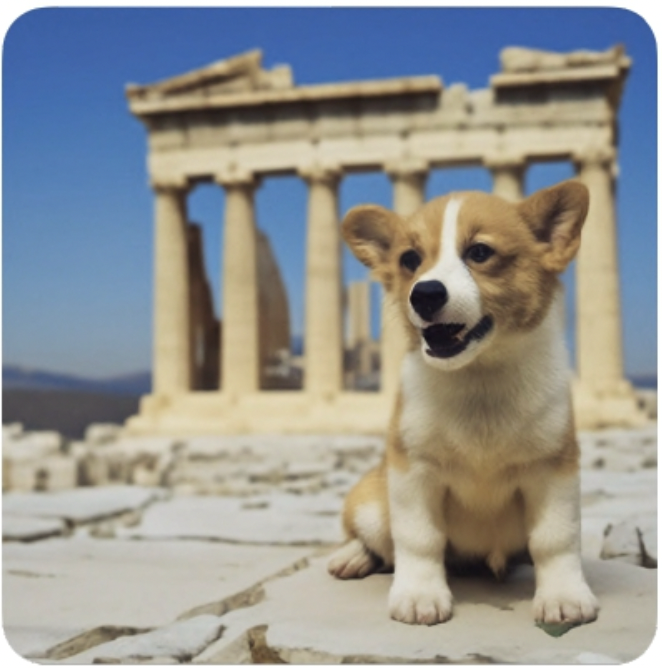

In [ ]:
ref_image = Image.open(file_name).convert('RGB')
ref_mask = cv2.imread(m_file_name)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
ref_image


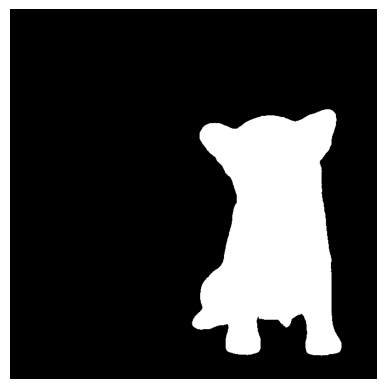

In [ ]:
show_(ref_mask)

In [ ]:
ref_w, ref_h = ref_image.size
ref_w, ref_h

(662, 668)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#| export
def get_image_embedding(
        im:Image,
        model:SamModel,
        processor:AutoProcessor,
        device:str="cuda",
        permute=True, # whether to permute the output of the model

        ):
    inputs = processor(images=im, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    model.to(device)
    with torch.no_grad():
        ref_feat = model.get_image_embeddings(pixel_values)
        if permute:
            ref_feat = ref_feat.squeeze().permute(1, 2, 0)
        else:
            ref_feat = ref_feat.squeeze()
    return inputs,ref_feat
    

In [ ]:
#| export
def get_preprocess_shape(
                         oldh:int,
                         oldw:int,
                         desired_size:int=1024,
                         ):
    'Compute output shape of preprocessing pipeline'

    scale = desired_size * 1 / max(oldh, oldw)
    newh, neww = int((oldh * scale) +.5), int((oldw * scale) +.5)
    return newh, neww


In [ ]:
#| export
def normalize_and_padding(
                         x:torch.Tensor,
                         pixel_mean:List[float]=[123.675, 116.28, 103.53],
                         pixel_std:List[float]=[58.395, 57.12, 57.375],
                         desired_size:int=1024
                         ):
    ' Noramlize and pad image to desired size'

    pixel_mean_ = torch.tensor(pixel_mean).view(-1, 1, 1)
    pixel_std_ = torch.tensor(pixel_std).view(-1, 1, 1)
    # Normalize
    x =( x- pixel_mean_) / pixel_std_

    #pad
    h, w = x.shape[-2:]
    padh = desired_size - h
    padw = desired_size - w
    return F.pad(x, (0, padw, 0, padh))


In [ ]:
#| export
def prepare_mask(
                 mask:Image,
                 desired_size:int=1024,
                 ):
    'Prepare mask for model input'

    target_size =  get_preprocess_shape(
        oldh=mask.shape[0],
        oldw=mask.shape[1],
        desired_size=desired_size)
    #mask = mask.resize((desired_size, desired_size), Image.NEAREST)
    mask = torch.as_tensor(np.array(resize(to_pil_image(mask), target_size)))
    mask = mask.permute(2, 0, 1).contiguous()[None, ...]
    mask_ = normalize_and_padding(mask)
    return mask_

In [ ]:
#| export
def get_target_object_in_ref_image(
        img:Image,
        msk:np.ndarray,
        model:SamModel,
        processor:AutoProcessor,
        device:str="cuda",
        print_:bool=True,
        ):
    ' Get target object in reference image'
    ref_mask = prepare_mask(msk)
    if print_:
        print(f' Normal ref mask has shape {ref_mask.shape}')

    _, ref_feat = get_image_embedding(img, model, processor, device=device, permute=True)

    if print_:
        print(f' Normal ref feat has shape {ref_feat.shape}')
        print('changing mask shape to match feature shape')
    ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0:2], mode="nearest")

    if print_:
        print(f'New ref mask has a shape of {ref_mask.shape}')
    ref_mask = ref_mask.squeeze()[0]

    # Get target object
    target_feat_ = ref_feat[ref_mask > 0]
    target_embedding = target_feat_.mean(0).unsqueeze(0)
    target_feat = target_embedding / target_embedding.norm(dim=-1, keepdim=True)
    target_embedding = target_embedding.unsqueeze(0)
    if print_:
        print(f' target_feat has shape {target_feat.shape}')
    return target_feat, target_embedding, ref_feat, ref_mask

    

In [ ]:
target_feat, target_embedding, ref_feat, ref_mask = get_target_object_in_ref_image(
    ref_image, 
    ref_mask, 
    model, 
    processor, 
    device=device,print_=False)

In [ ]:
target_embedding.shape

torch.Size([1, 1, 256])

# Test image

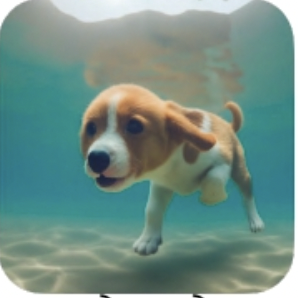

In [ ]:
tst_im_path = hf_hub_download(
    repo_id="nielsr/persam-dog", 
    filename="new_dog.jpg", 
    repo_type="dataset")
tst_img = Image.open(tst_im_path).convert('RGB')
tst_img

# Test image embedding

In [ ]:
inputs, tst_feat = get_image_embedding(
    tst_img, 
    model,
    processor, 
    device=device, 
    permute=False)
tst_feat.shape

torch.Size([256, 64, 64])

# Cosine similarity

In [ ]:
#| export
def get_norm_(x:torch.Tensor):
    ' Calcualte norm of x'
    return  x / x.norm(dim=0, keepdim=True)

In [ ]:
#| export
def get_cosine_sim(
    trgt_feat:torch.Tensor,
    tst_feat:torch.Tensor,
    scale:bool=True,
    print_:bool=True,
    ):
    ' Calculate cosine similarity between tst and target image'

    c, h, w = tst_feat.shape
    tst_feat_norm = get_norm_(tst_feat)
    tst_feat_norm_r = tst_feat_norm.reshape(
        c, 
        h*w
    )
    sim = trgt_feat @ tst_feat_norm_r
    sim = sim.reshape(1, 1, h, w)
    if scale:
        scale_factor = target_feat.shape[-1] // tst_feat.shape[-1]
        if print_:
            print(f'scaling simimlarty metrics by {scale_factor}')
        sim = F.interpolate(
            sim, 
            scale_factor=scale_factor,
            mode='bilinear',
        )
        return sim
    else:
        return sim


In [ ]:
sim_ = get_cosine_sim(
    target_feat, 
    tst_feat, 
    scale=False
   )
sim_.shape

torch.Size([1, 1, 64, 64])

In [ ]:
#| export
def post_process_masks(
        sim_:torch.Tensor,
        inputs:dict,
        processor:AutoProcessor,
     ):
    pr_sim = processor.post_process_masks(
        sim_.unsqueeze(1), 
        original_sizes=inputs["original_sizes"].tolist(), 
        reshaped_input_sizes=inputs["reshaped_input_sizes"].tolist(),
                                    binarize=False)
    return pr_sim[0].squeeze()


In [ ]:
sim_s = post_process_masks(sim_,inputs=inputs, processor=processor)
sim_s.shape

torch.Size([298, 298])

In [ ]:
sim_sn = sim_s.cpu().numpy()

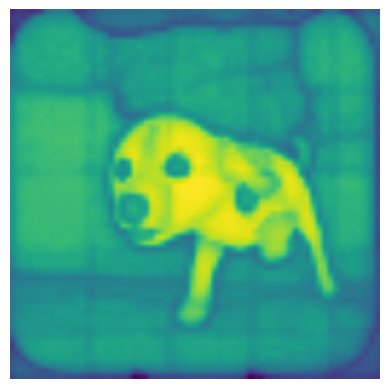

In [ ]:
show_(sim_sn)

# Obtain target guided attention prior

In [ ]:
#| export
def tg_attention_layer(
    sim:torch.Tensor,
    print_:bool=True,
    ):
    'Get target guided attention layer'
    sim = (sim - sim.mean()) / torch.std(sim)
    if print_:
        print(f' sim has shape {sim.shape}')
    sim_ = F.interpolate(
        sim.unsqueeze(0).unsqueeze(0),
        size=(64, 64),
         mode='bilinear')
    if print_:
        print(f' sim_ has shape {sim_.shape}')
    attention_similarity = sim_.sigmoid_().unsqueeze(0).flatten(3)
    if print_:
        print(f' attention_similarity has shape {attention_similarity.shape}')
    return attention_similarity



In [ ]:
att_sim = tg_attention_layer(sim_s, print_=False)

# Obtain positive(foreground) and background(background) masks

In [ ]:
#| export
def point_selection(
        mask_sim, 
        topk=1):
    ' Top-1 point selection'
    w, h = mask_sim.shape
    topk_xy = mask_sim.flatten(0).topk(topk)[1]
    topk_x = (topk_xy // h).unsqueeze(0)
    topk_y = (topk_xy - topk_x * h)
    topk_xy = torch.cat((topk_y, topk_x), dim=0).permute(1, 0)
    topk_label = np.array([1] * topk)
    topk_xy = topk_xy.cpu().numpy()
        
    # Top-last point selection
    last_xy = mask_sim.flatten(0).topk(topk, largest=False)[1]
    last_x = (last_xy // h).unsqueeze(0)
    last_y = (last_xy - last_x * h)
    last_xy = torch.cat((last_y, last_x), dim=0).permute(1, 0)
    last_label = np.array([0] * topk)
    last_xy = last_xy.cpu().numpy()
    
    return topk_xy, topk_label, last_xy, last_label

In [ ]:
#| export
def get_pos_neg_lp(
        sim:torch.Tensor, # similarity metrics resized
        topk:int=1,# number of similar component to take
        ):
    ' get positive and negative location prior'
    topk_xy_i, topk_label_i, \
        last_xy_i, last_label_i = point_selection(
                                        sim, topk=1)
    topk_xy = np.concatenate(
        [topk_xy_i, last_xy_i], 
        axis=0)
    topk_label = np.concatenate(
        [topk_label_i, last_label_i], 
        axis=0)
    return topk_xy, topk_label


In [ ]:
topk_xy, topk_label = get_pos_neg_lp(sim_s, topk=1)
topk_xy, topk_label

(array([[151, 123],
        [193, 296]]),
 array([1, 0]))

In [ ]:
#| export
def frm_tst_img_to_a_sim(
        target_feat:torch.Tensor,# ref image embedding
        tst_img:Image, # test image it should be PIL
        model:SamModel,
        processor:AutoProcessor,
        device:str="cuda",
        print_:bool=True,
       ):
    'From test image to attention similarity and points for SAM'
    inputs, tst_feat = get_image_embedding(
    tst_img, 
    model,
    processor, 
    device=device, 
    permute=False)
    if print_:
        print(f' tst_feat has shape {tst_feat.shape}')

    sim_ = get_cosine_sim(
        target_feat, 
        tst_feat, 
        scale=False,
        print_=print_
    )
    if print_:
        print(f' Similarity has a shape of {sim_.shape}')


    sim_s = post_process_masks(
                                sim_, 
                                processor=processor, 
                                inputs=inputs)
    if print_:
        print(f'After post processing similarity has a shape of {sim_s.shape}')

    att_sim = tg_attention_layer(sim_s, print_=print_)
    topk_xy, topk_label = get_pos_neg_lp(sim_s, topk=1)
    return tst_feat, att_sim, topk_xy, topk_label

In [ ]:
#| export
def get_first_prediction(
    ref_img:Image,
    ref_msk:np.ndarray,
    tst_img:Image,
    model:SamModel,
    processor:AutoProcessor,
    device:str="cuda",
    print_:bool=True,

    ):

    target_feat, target_embedding, ref_feat, ref_mask = get_target_object_in_ref_image(
        ref_img, 
        ref_msk, 
        model, 
        processor, 
        device=device, 
        print_=print_)
    if print_:print(f'target_feat has shape {target_feat.shape}')

    tst_feat, att_sim, topk_xy, topk_label = frm_tst_img_to_a_sim(
                                                target_feat, 
                                                tst_img, 
                                                model, 
                                                processor, 
                                                device=device,
                                                print_=print_)
    input_sam = processor(
        images=tst_img, 
        input_points = [topk_xy.tolist()],
        input_labels=[topk_label.tolist()],
        return_tensors="pt",
        )
    input_sam = input_sam.to(device)

    
    with torch.no_grad():
        outputs = model(
            input_points=input_sam.input_points, 
            input_labels=input_sam.input_labels,
            image_embeddings=tst_feat.unsqueeze(0),
            multimask_output=False,
            attention_similarity=att_sim,  # Target-guided Attention
            target_embedding=target_embedding  # Target-semantic Prompting
        )
        best_idx = 0
    return outputs, tst_feat, topk_xy, topk_label, input_sam,best_idx


In [ ]:
tst_im_path = hf_hub_download(
    repo_id="nielsr/persam-dog", 
    filename="new_dog.jpg", 
    repo_type="dataset")
ref_image = Image.open(file_name).convert('RGB')
ref_mask = cv2.imread(m_file_name)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
tst_img = Image.open(tst_im_path).convert('RGB')

In [ ]:
outputs, tst_feat,topk_xy, topk_label, input_sam, best_idx = get_first_prediction(
                                        ref_img=ref_image,
                                        ref_msk=ref_mask,
                                        tst_img=tst_img,
                                        model=model,
                                        processor=processor, print_=False)


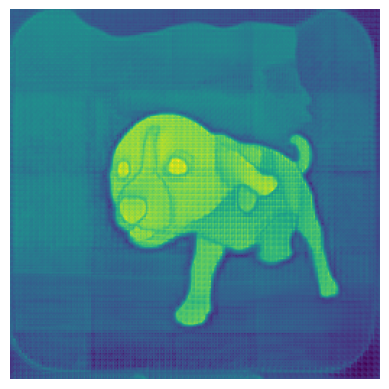

In [ ]:
show_(outputs['pred_masks'].to('cpu').numpy()[0][0][0])

In [ ]:
best_idx

0

In [ ]:
#| export
def get_first_refined_mask(
    ref_image:Image,
    ref_mask:np.ndarray,
    tst_img:Image,
    processor:AutoProcessor,
    model:SamModel,
    device:str,
    print_:bool
    ):
    ' Refined mask creattion after first prediction'

    outputs, tst_feat,topk_xy, topk_label, input_sam, best_idx = get_first_prediction(
                                        ref_img=ref_image,
                                        ref_msk=ref_mask,
                                        tst_img=tst_img,
                                        model=model,
                                        print_=print_,
                                        device=device,
                                        processor=processor)

    with torch.no_grad():
        outputs_1 = model(
                input_points=input_sam.input_points, 
                input_labels=input_sam.input_labels,
                input_masks=outputs.pred_masks.squeeze(1)[best_idx: best_idx + 1, :, :], 
                image_embeddings=tst_feat.unsqueeze(0),
                multimask_output=True)

    masks = processor.post_process_masks(
        outputs_1['pred_masks'], 
        original_sizes=input_sam['original_sizes'].cpu(), 
        reshaped_input_sizes=input_sam['reshaped_input_sizes'].cpu(),
    )
    return outputs_1, masks[0].squeeze().cpu().numpy()


In [ ]:
outputs, masks = get_first_refined_mask(
    ref_image=ref_image,
    ref_mask=ref_mask,
    tst_img=tst_img,
    processor=processor,
    model=model,
    device='cuda',
    print_=False
)

In [ ]:
outputs['iou_scores']

tensor([[[0.6888, 0.9921, 0.8882]]], device='cuda:0')

In [ ]:
with torch.no_grad():
  outputs_1 = model(
              input_points=input_sam.input_points, 
              input_labels=input_sam.input_labels,
              input_masks=outputs.pred_masks.squeeze(1)[best_idx: best_idx + 1, :, :], 
              image_embeddings=tst_feat.unsqueeze(0),
              multimask_output=True)

In [ ]:
outputs_1.keys()

odict_keys(['iou_scores', 'pred_masks'])

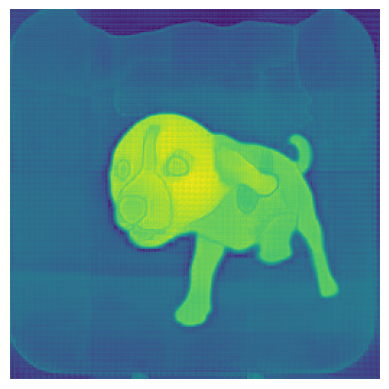

In [ ]:

show_(outputs_1['pred_masks'].to('cpu').numpy()[0][0][1])

In [ ]:
outputs_1['iou_scores']

tensor([[[0.6888, 0.9921, 0.8882]]], device='cuda:0')

In [ ]:
masks = processor.post_process_masks(
    outputs_1['pred_masks'], 
    original_sizes=inputs['original_sizes'].cpu(), 
    reshaped_input_sizes=inputs['reshaped_input_sizes'].cpu(),
)
masks[0].shape

torch.Size([1, 3, 298, 298])

In [ ]:
masks_ = masks[0].squeeze().cpu().numpy()

In [ ]:
masks_.shape

(3, 298, 298)

In [ ]:
best_idx = outputs_1['iou_scores'].argmax().item()
best_idx

1

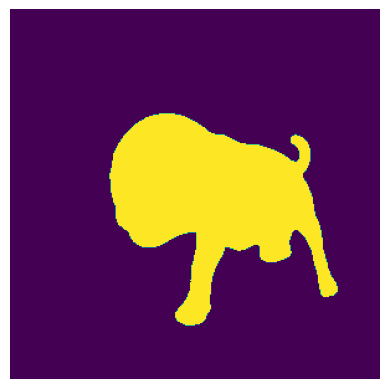

In [ ]:
show_(masks_[best_idx])

In [ ]:
y, x = np.nonzero(masks_[best_idx])
input_boxes = [[[x.min(), y.min(), x.max(), y.max()]]]
inputs = processor(
    tst_img,
    input_points=[topk_xy.tolist()],
    input_labels=[topk_label.tolist()],
    input_boxes=input_boxes,
    return_tensors="pt").to(device)



In [ ]:
y, x = np.nonzero(masks_[best_idx])
final_outputs = model(
    input_points=inputs.input_points, 
    input_labels=inputs.input_labels,
    input_boxes=inputs.input_boxes,
    input_masks=outputs_1.pred_masks.squeeze(1)[:,best_idx: best_idx + 1, :, :], 
    image_embeddings=tst_feat.unsqueeze(0),
    multimask_output=True)

In [ ]:
masks = processor.image_processor.post_process_masks(
    final_outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(), 
    inputs["reshaped_input_sizes"].cpu())[0].squeeze().numpy()
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 297.5, 297.5, -0.5)

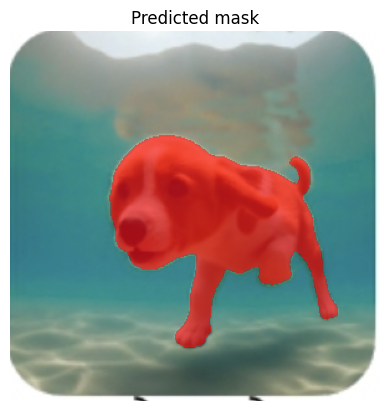

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255, 0, 0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

best_idx = torch.argmax(final_outputs.iou_scores).item()
axes.imshow(np.array(tst_img))
show_mask(masks[best_idx], axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [ ]:
import nbdev; nbdev.nbdev_export('02_auto_test.ipynb')